# Orchestrating Jobs, Model Registration, and Continuous Deployment with Amazon SageMaker

Amazon SageMaker offers Machine Learning application developers and Machine Learning operations engineers the ability to orchestrate SageMaker jobs and author reproducible Machine Learning pipelines, deploy custom-build models for inference in real-time with low latency or offline inferences with Batch Transform, and track lineage of artifacts. You can institute sound operational practices in deploying and monitoring production workflows, deployment of model artifacts, and track artifact lineage through a simple interface, adhering to safety and best-practice paradigmsfor Machine Learning application development.

The SageMaker Pipelines service supports a SageMaker Machine Learning Pipeline Domain Specific Language (DSL), which is a declarative Json specification. This DSL defines a Directed Acyclic Graph (DAG) of pipeline parameters and SageMaker job steps. The SageMaker Python Software Developer Kit (SDK) streamlines the generation of the pipeline DSL using constructs that are already familiar to engineers and scientists alike.

The SageMaker Model Registry is where trained models are stored, versioned, and managed. Data Scientists and Machine Learning Engineers can compare model versions, approve models for deployment, and deploy models from different AWS accounts, all from a single Model Registry. SageMaker enables customers to follow the best practices with ML Ops and getting started right. Customers are able to standup a full ML Ops end-to-end system with a single API call.

## SageMaker Pipelines

Amazon SageMaker Pipelines support the following activites:

* Pipelines - A Directed Acyclic Graph of steps and conditions to orchestrate SageMaker jobs and resource creation.
* Processing Job steps - A simplified, managed experience on SageMaker to run data processing workloads, such as feature engineering, data validation, model evaluation, and model interpretation.
* Training Job steps - An iterative process that teaches a model to make predictions by presenting examples from a training dataset.
* Conditional step execution - Provides conditional execution of branches in a pipeline.
* Registering Models - Creates a model package resource in the Model Registry that can be used to create deployable models in Amazon SageMaker.
* Creating Model steps - Create a model for use in transform steps or later publication as an endpoint.
* Parameterized Pipeline executions - Allows pipeline executions to vary by supplied parameters.
* Transform Job steps - A batch transform to preprocess datasets to remove noise or bias that interferes with training or inference from your dataset, get inferences from large datasets, and run inference when you don't need a persistent endpoint.

## Layout of the SageMaker ModelBuild Project Template

The template provides a starting point for bringing your SageMaker Pipeline development to production.

```
|-- codebuild-buildspec.yml
|-- CONTRIBUTING.md
|-- pipelines
|   |-- abalone
|   |   |-- evaluate.py
|   |   |-- __init__.py
|   |   |-- pipeline.py
|   |   `-- preprocess.py
|   |-- get_pipeline_definition.py
|   |-- __init__.py
|   |-- run_pipeline.py
|   |-- _utils.py
|   `-- __version__.py
|-- README.md
|-- sagemaker-pipelines-project.ipynb
|-- setup.cfg
|-- setup.py
|-- tests
|   `-- test_pipelines.py
`-- tox.ini
```

A description of some of the artifacts is provided below:
<br/><br/>
Your codebuild execution instructions:
```
|-- codebuild-buildspec.yml
```
<br/><br/>
Your pipeline artifacts, which includes a pipeline module defining the required `get_pipeline` method that returns an instance of a SageMaker pipeline, a preprocessing script that is used in feature engineering, and a model evaluation script to measure the Mean Squared Error of the model that's trained by the pipeline:

```
|-- pipelines
|   |-- abalone
|   |   |-- evaluate.py
|   |   |-- __init__.py
|   |   |-- pipeline.py
|   |   `-- preprocess.py

```
<br/><br/>
Utility modules for getting pipeline definition jsons and running pipelines:

```
|-- pipelines
|   |-- get_pipeline_definition.py
|   |-- __init__.py
|   |-- run_pipeline.py
|   |-- _utils.py
|   `-- __version__.py
```
<br/><br/>
Python package artifacts:
```
|-- setup.cfg
|-- setup.py
```
<br/><br/>
A stubbed testing module for testing your pipeline as you develop:
```
|-- tests
|   `-- test_pipelines.py
```
<br/><br/>
The `tox` testing framework configuration:
```
`-- tox.ini
```

### A SageMaker Pipeline

The pipeline that we create follows a typical Machine Learning Application pattern of pre-processing, training, evaluation, and conditional model registration and publication, if the quality of the model is sufficient.

![A typical ML Application pipeline](img/pipeline-full.png)

### Getting some constants

We get some constants from the local execution environment.

### All of thepipeline is embedded here with steps

In [396]:
import boto3
import sagemaker


region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sm_session = sagemaker.session.Session(default_bucket="sagemaker-grewaltempl")
default_bucket = sm_session.default_bucket()

# Change these to reflect your project/business name or if you want to separate ModelPackageGroup/Pipeline from the rest of your team
model_package_group_name = f"TweetsModelPackageGroup-Example1"
pipeline_name = f"TweetsPipeline-Example1"

In [397]:
import os

import boto3
import sagemaker
import sagemaker.session

from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.model_metrics import (
    MetricsSource,
    ModelMetrics,
)
from sagemaker.processing import (
    ProcessingInput,
    ProcessingOutput,
    ScriptProcessor,
    FrameworkProcessor
)
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import (
    ConditionStep,
    JsonGet,
)
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.steps import (
    ProcessingStep,
    TrainingStep,
)
from sagemaker.workflow.step_collections import RegisterModel

from sagemaker.workflow.conditions import (
    ConditionGreaterThanOrEqualTo,
)

from sagemaker.sklearn import SKLearnModel
from sagemaker.xgboost import XGBoostModel
from sagemaker.model import Model

from sagemaker.workflow.steps import CreateModelStep

import warnings
warnings.simplefilter('ignore')
warnings.filterwarnings('ignore')

In [398]:
## -- Common constants
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)
from sagemaker.workflow.properties import PropertyFile

from sagemaker.processing import ProcessingInput, ProcessingOutput
import os

print(f"Using:role={role}:")
print(f"using SageMaker session={sm_session}:")

BASE_JOB_PREFIX="smjobs",  # Choose any name
BASE_DIR = os.path.dirname(os.path.realpath('__file__'))
BASE_DIR = BASE_DIR + "/pipelines/tweets" # -- to simulate this jupyter file running where the pipelines will run

# Parameters for pipeline execution
processing_instance_count = ParameterInteger(
        name="ProcessingInstanceCount", default_value=1
)
processing_instance_type = ParameterString(
        name="ProcessingInstanceType", default_value="ml.m5.xlarge"
)
training_instance_type = ParameterString(
        name="TrainingInstanceType", default_value="ml.m5.xlarge"
)
model_approval_status = ParameterString(
        name="ModelApprovalStatus",
        default_value="PendingManualApproval",  # ModelApprovalStatus can be set to a default of "Approved" if you don't want manual approval.
)
input_data = ParameterString(
        name="InputDataUrl",
        default_value=f"s3://{default_bucket}/data/finance/combined_tweets.csvv",  # Change this to point to the s3 location of your raw input data.
)
print(f"pipeline:get_pipeline::processor:")
# Cache Pipeline steps to reduce execution time on subsequent executions

from sagemaker.workflow.steps import CacheConfig
cache_config = CacheConfig(enable_caching=True, expire_after="1d")
print(f"pipeline::get_pipeline:cache:config:enabled:")


pipeline_name="SageMakerTweetsPipeline"  # You can find your pipeline name in the Studio UI (project -> Pipelines -> name)
base_job_prefix="tweets-pipeline" # Choose any name

print(f"Pipeline_name={pipeline_name}:")
print(f"Pipeline:base:job:prefix={base_job_prefix}:")

Using:role=arn:aws:iam::034150676293:role/service-role/AmazonSageMaker-ExecutionRole-20220322T185187:
using SageMaker session=<sagemaker.session.Session object at 0x7eff4f7a9c10>:
pipeline:get_pipeline::processor:
pipeline::get_pipeline:cache:config:enabled:
Pipeline_name=SageMakerTweetsPipeline:
Pipeline:base:job:prefix=tweets-pipeline:


In [399]:
type(base_job_prefix)

str

### PRE PROC SCRIPTS AND STEPS

In [400]:
%%writefile ./pipelines/tweets/preprocess_tweets.py
"""Feature engineers the Tweets churn dataset."""
import argparse
import logging
import os
import pathlib
import requests
import tempfile

import boto3
import numpy as np
import pandas as pd

import json

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

_logger = logging.getLogger()
_logger.setLevel(logging.INFO)
_logger.addHandler(logging.StreamHandler())

try:
    _logger.info(f"Pandas:version:{pd.__version__}")
    _logger.info(f"Numpy:version:{np.__version__}")
    import xgboost as xgb
    _logger.info(f"XGBoost:version:{xgb.__version__}")
except:
    pass


# Since we get a headerless CSV file we specify the column names here.

X_columns_names =  [
    'tweet_id', 
    'writer', 
    'post_date', 
    'body', 
    'comment_num', 
    'retweet_num',
    'like_num', 
    'ticker_symbol'
]

Y_column = "high_price"


X_columns_dtype = {
    'tweet_id': np.float64, 
    'writer': str, 
    'post_date': np.int64, 
    'body': str, 
    'comment_num': np.int64, 
    'retweet_num': np.int64, 
    'like_num': np.int64, 
    'ticker_symbol': str
}
Y_column_dtype = {Y_column: np.bool} #{Y_column: np.float64}


def merge_two_dicts(x, y):
    """Merges two dicts, returning a new copy."""
    z = x.copy()
    z.update(y)
    return z

def listLocalDirectory(dirPath="."):
    for path, dnames, fnames in os.walk(dirPath):
        _logger.info(f"List::path={path}::dirNames={dnames}::fileNames={fnames}::")

def textToVectors(text, vectorizer):
    vector = vectorizer.transform([text])
    return sum(vector.toarray()[0])

def vectorizerText(textArray):
    from sklearn.feature_extraction.text import TfidfVectorizer
    # create the transform
    vectorizer = TfidfVectorizer()
    # tokenize and build vocab
    vectorizer.fit(textArray)
    return vectorizer
       
if __name__ == "__main__":
    _logger.info("Starting preprocessing.")
    parser = argparse.ArgumentParser()
    parser.add_argument("--input-data", type=str, required=True)
    parser.add_argument("--data-size", type=int, default=100)
    args = parser.parse_args()
    input_data = args.input_data
    data_size = args.data_size
    _logger.info(f"Data size={data_size}::")
    
    
    BASE_DIR = "/opt/ml/processing"
    pathlib.Path(f"{BASE_DIR}/data").mkdir(parents=True, exist_ok=True)
    _logger.info(f"Download:data:from:s3:to:local:location:={BASE_DIR}/data::")
    
    print(input_data)
    _logger.info(f"Input:data:={input_data}::")
    
    bucket = input_data.split("/")[2]
    key = "/".join(input_data.split("/")[3:])

    _logger.info(f"TEST:TEST:Downloading data from bucket: {bucket}, key: {key}:Willdownload to localfile:name as raw-data.csv")
    fn = f"{BASE_DIR}/data/raw-data.csv"
    try:
        s3 = boto3.resource("s3")
        s3.Bucket(bucket).download_file(key, fn)
    except:
        _logger.error("TEST:TEST:error:in:downloading:from:s3:ignore")

    

    #fn = os.path.join("/opt/ml/processing/input", "combined_tweets.csv")
    
    onlyFiles = [f for f in os.listdir("/opt/ml/processing/input") if os.path.isfile(os.path.join("/opt/ml/processing/input", f))]
    _logger.info(f"Data Downloaded::Now Reading downloaded data.:dir:/opt/ml/processing/input::And:FILES:ARE::{onlyFiles}")
    
    fn = os.path.join("/opt/ml/processing/input", onlyFiles[0])
    _logger.info(f"Data Downloaded::Now Reading downloaded data.:dir:/opt/ml/processing/input:::from:location={fn}::")
    
    # read in csv
    combinedTweetsDF = pd.read_csv(fn)
    combinedTweetsDF = combinedTweetsDF.dropna()
    combinedTweetsDF = combinedTweetsDF.drop_duplicates() # -- this drops duplicates

    # -- FOR NOW CREATE just a 10 ROW DATA SET for FASTER processing
    combinedTweetsDF =  combinedTweetsDF.iloc[:data_size,:]
    # -- END 10 row data set creation
    _logger.info(f"After:ILOC:shape={combinedTweetsDF.shape}:")
    
    # Create one binary classification target column
    combinedTweetsDF['body_length'] = combinedTweetsDF['body'].apply( lambda x: len(x))
    combinedTweetsDF['Y_label'] = combinedTweetsDF['body_length'].apply( lambda x: 1 if x > 115 else 0)
    #combinedTweetsDF['Y_label'] = combinedTweetsDF.Y_label.apply(lambda x: 1 if x else 0) # -- convert to 1 and 0
    _logger.info(f"After:transformation:shape={combinedTweetsDF.shape}:columns={combinedTweetsDF.columns}::describe={combinedTweetsDF.describe()}::")
     
    # Convert categorical variables into dummy/indicator variables.
    #categorical_cols=['writer', 'ticker_symbol']
    #categorical_cols_dict ={'writer':'wr', 'ticker_symbol' :'ticker' }
    #df_multi = pd.get_dummies(combinedTweetsDF, columns=categorical_cols, prefix=categorical_cols_dict, drop_first=True)
    df_multi = combinedTweetsDF.reindex(columns=(['Y_label'] + list([a for a in combinedTweetsDF.columns if a != 'Y_label']) ))
    _logger.info(f"df_multi:BEFORE:DROP:BODY:first 10 cols = {df_multi.columns[:10]}::")
    
    # -- vectorize the text 
    #df_multi = df_multi[1:] # remove the header row 
    vectorizer = vectorizerText(df_multi.body)
    df_multi['vec_text'] = df_multi.body.apply(lambda x: textToVectors(x,vectorizer ))
    df_multi = df_multi.drop(['body'], axis=1)
    _logger.info(f"After:Vectorization:columns={len(df_multi.columns)}::describe={df_multi.describe()}::")
    _logger.info(f"After:Vectorization:shape of data set={df_multi.shape}::len={len(df_multi)}::")
    
    # -- vectorize the Writer and ticker symbol

    vectorizer = vectorizerText(df_multi.writer.dropna())
    df_multi['writer_text'] = df_multi.writer.apply(lambda x: textToVectors(x,vectorizer ))
    df_multi = df_multi.drop(['writer'], axis=1)

    vectorizer = vectorizerText(df_multi.ticker_symbol.dropna())
    df_multi['ticker_symbol_text'] = df_multi.ticker_symbol.apply(lambda x: textToVectors(x,vectorizer ))
    df_multi = df_multi.drop(['ticker_symbol'], axis=1)

    _logger.info(f"After:FULL:Vectorization:columns={len(df_multi.columns)}::describe={df_multi.describe()}::")
    _logger.info(f"After:FULL:Vectorization:shape of data set={df_multi.shape}::len={len(df_multi)}::")


    
    # Split the data
    train_data, val_data, test_data = np.split(
        df_multi.sample(frac=1, random_state=1729),
        [int(0.7 * len(df_multi)), int(0.9 * len(df_multi))],
    )
    _logger.info(f"Going to write it to {BASE_DIR}/train and {BASE_DIR}/test and {BASE_DIR}/val")
    _logger.info(f"train_data:len={len(train_data)}::  val_data:len={len(val_data)}::  test_data:len={len(test_data)}::")
    pd.DataFrame(train_data).to_csv(
        f"{BASE_DIR}/train/train.csv", header=False, index=False
    )
    pd.DataFrame(val_data).to_csv(
        f"{BASE_DIR}/val/val.csv", header=False, index=False
    )
    pd.DataFrame(test_data).to_csv(
        f"{BASE_DIR}/test/test.csv", header=False, index=False
    )
    
    report_dict = {
        "regression_metrics": {
            "mse": {
                "value": 11.1,
                "standard_deviation": 89.2
            },
        },
    }

    output_dir = "/opt/ml/processing/evalproperty"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    _logger.info("Evaluation:Writing out evaluation report with mse: %f", 11.1)
    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

    _logger.info("Evaluation: All Done !!")    
    
    
    _logger.info("All Done !! written out !!")
    
    # ----------------   OLD TEMPLATE CODE --------------------#


Overwriting ./pipelines/tweets/preprocess_tweets.py


In [401]:
# Processing step for feature engineering
sklearn_processor = SKLearnProcessor(
        framework_version="0.23-1",
        instance_type=processing_instance_type,
        instance_count=processing_instance_count,
        base_job_name=f"smjobs-sklearn-tweets-preprocess/{base_job_prefix}" ,#f"{BASE_JOB_PREFIX}-sklearn-TweetsChurn-preprocess",  # choose any name
        sagemaker_session=sm_session,
        role=role,
    )

inputs_p=[
    ProcessingInput(
        source=f"s3://{default_bucket}/data/finance/combined_tweets.csv",
        destination='/opt/ml/processing/input'
    ),
 ]
outputs_p=[
    ProcessingOutput(
        s3_upload_mode="EndOfJob",
        output_name='train',
        source='/opt/ml/processing/train',
        destination=f's3://{default_bucket}/data/finance/curated/small/train'
    ),
    ProcessingOutput(
        s3_upload_mode="EndOfJob",
        output_name='test',
        source='/opt/ml/processing/test',
        destination=f's3://{default_bucket}/data/finance/curated/small/test'
    ),
    ProcessingOutput(
        s3_upload_mode="EndOfJob",
        output_name='validation',
        source='/opt/ml/processing/val',
        destination=f's3://{default_bucket}/data/finance/curated/small/validation'
    ),
    ProcessingOutput(
        output_name="evaluation-property-pass",
        source="/opt/ml/processing/evalproperty",
        destination=f's3://{default_bucket}/data/finance/curated/small/evalproperty'
    ),
    
    
]
# -- if we d onot create a output then this directory is never creatd on tbe processing job
evaluation_report_preproc = PropertyFile(
    name="EvaluationReportPreproc",
    output_name="evaluation-property-pass", # -- matches the processing output name
    path="evaluation.json",
)

job_arguments_p=["--input-data", f"s3://{default_bucket}/data/finance/combined_tweets.csv", 
              "--data-size", "10000"]
step_process = ProcessingStep(
        name="PreProcTweetsModelPipe",  # choose any name
        processor=sklearn_processor,
        inputs=inputs_p,
        outputs=outputs_p,
        property_files=[evaluation_report_preproc],
        code=os.path.join(BASE_DIR, "preprocess_tweets.py"),
        job_arguments=job_arguments_p,
        cache_config=cache_config
    )    
    
print(f"SageMaker:pipeline:get_pipeline::Preproc:step:added={step_process}")


SageMaker:pipeline:get_pipeline::Preproc:step:added=ProcessingStep(name='PreProcTweetsModelPipe', display_name=None, description=None, step_type=<StepTypeEnum.PROCESSING: 'Processing'>, depends_on=None)


### Now the Training step

In [402]:
%%writefile ./pipelines/tweets/modeltrain.py

import os

import pandas as pd
from sklearn.linear_model import LogisticRegression
#from sklearn.externals import joblib
import logging
import joblib
import pickle
import xgboost as xgb
import argparse
import json

_logger = logging.getLogger()
_logger.setLevel(logging.INFO)
_logger.addHandler(logging.StreamHandler())

def merge_two_dicts(x, y):
    """Merges two dicts, returning a new copy."""
    z = x.copy()
    z.update(y)
    return z

def listLocalDirectory(dirPath="."):
    for path, dnames, fnames in os.walk(dirPath):
        _logger.info(f"List::path={path}::dirNames={dnames}::fileNames={fnames}::")

def textToVectors(text, vectorizer):
    vector = vectorizer.transform([text])
    return sum(vector.toarray()[0])

def vectorizerText(textArray):
    from sklearn.feature_extraction.text import TfidfVectorizer
    # create the transform
    vectorizer = TfidfVectorizer()
    # tokenize and build vocab
    vectorizer.fit(textArray)
    return vectorizer

def model_fn(model_dir):
    model = xgb.Booster()
    try:
        model.load_model(os.path.join(model_dir,'xgboost-model.json'))
    except:
        #ignore model must be of type xgboost-model
        print("error in loading the JSON version of xgboost model")
        model.load_model(os.path.join(model_dir,'xgboost-model'))
        
    return model

#####  Estimator does not use the entry point script you have to use the sklearn container
#####  so for estimator xgboost 1.01 that is in pickle format and so has to be loaded as pickle
#####  -- since  weh have 1.5 version of xgboost -- we have to save it as json and then reload it and then do the predictions ---
#####  that will solve the problem 

####  SO THIS CLASS IS NOT REALLY USED UNLESS we use sklearn estimator 

def _parse_args():
    parser = argparse.ArgumentParser()

    # Data, model, and output directories
    # model_dir is always passed in from SageMaker. By default this is a S3 path under the default bucket.
    parser.add_argument('--model_dir', type=str)
    parser.add_argument('--sm-model-dir', type=str, default=os.environ.get('SM_MODEL_DIR'))
    parser.add_argument('--train', type=str, default=os.environ.get('SM_CHANNEL_TRAINING'))
    parser.add_argument('--hosts', type=list, default=json.loads(os.environ.get('SM_HOSTS')))
    parser.add_argument('--current-host', type=str, default=os.environ.get('SM_CURRENT_HOST'))

    return parser.parse_known_args()


if __name__ == "__main__":
    _logger.info(f"Model:xgboost:version:{xgb.__version__}")
    args, unknown_args = _parse_args()
    _logger.info(f"Model:xgboost:unknown_args={unknown_args}::args={args}::")
    
    training_data_directory = "/opt/ml/input/data/train"
    train_data = os.path.join(training_data_directory, "train.csv")
    _logger.info(f"Model:Logistic:regression:Reading input data from {training_data_directory}:")

    train_df = pd.read_csv(train_data, header=None)
    X_train = train_df.iloc[:,1:]
    y_train = train_df.iloc[:,:1]
    _logger.info(f"Model:train_df={train_df.shape}::X_train:shape={X_train.shape}:: y_train={y_train.shape}::")
     
    #model = LogisticRegression(class_weight="balanced", solver="lbfgs")
    param_dict = { 'objective':'binary:logistic'}
    model = xgb.XGBClassifier(**param_dict)
    _logger.info("Model:Training XGBOOST model")
    model.fit(X_train, y_train)
    
    #model_output_directory = os.path.join("/opt/ml/model", "model.joblib")
    #model_output_directory = os.path.join("/opt/ml/model", "xgboost-model.pkl")
    #_logger.info("OLDER:PKL:Model:Saving model to {}".format(model_output_directory))
    
    #pickle.dump(model, open(model_output_directory, 'wb'))
    #joblib.dump(model, model_output_directory)
    
    model_output_directory = os.path.join("/opt/ml/model", "xgboost-model.json")
    _logger.info("Model:Saving model to {}".format(model_output_directory))
    model.save_model(model_output_directory)

    _logger.info("Model:Trained:ALL Done added !!!")

       
    
    # ----------------   OLD TEMPLATE CODE --------------------#


Overwriting ./pipelines/tweets/modeltrain.py


In [403]:
import boto3
from sagemaker.xgboost.estimator import XGBoost
from sagemaker import TrainingInput

# -- CANNOT USE this for Sagemaker Algorithims 
metrics_definetion = [
        {'Name': 'train:loss', 'Regex': 'loss: ([0-9\\.]+)'},
        {'Name': 'train.accuracy', 'Regex': 'accuracy: ([0-9\\.]+)'},
        {'Name': 'validation.loss', 'Regex': 'val_loss: ([0-9\\.]+)'},
        {'Name': 'validation.accuracy', 'Regex': 'val_accuracy: ([0-9\\.]+)'},
]
xgb_hyperparams = dict (
        objective="reg:linear",
        num_round=50,
        max_depth=5,
        eta=0.2,
        gamma=4,
        min_child_weight=6,
        subsample=0.7,
        silent=0,
    )

use_spot_instances = True
max_run = 3600
max_wait = 7200 if use_spot_instances else None

xgb_custom_estimator = XGBoost(
    role=role, 
    entry_point=os.path.join(BASE_DIR, 'modeltrain.py'),
    framework_version="1.3-1",
    instance_count=1,
    instance_type='ml.m5.large', # - 'local', only if docker is installed locally 
    output_path=f's3://{default_bucket}/pipeline/model/xgbtrain/modeltweet',
    use_spot_instances=use_spot_instances,
    max_run=max_run,
    max_wait=max_wait,
    hyperparameters=xgb_hyperparams,
    base_job_name=f"TrainTweetsModelPipe/{base_job_prefix}",
    code_location=f"s3://{default_bucket}/pipeline/model/xgbtrain/code", 
    #source_dir="scripts", # This line will tell SageMaker to first install defined dependencies from scrits/requirements.txt,
    # -- and then to upload all code inside of this folder to your container.
    #metric_definitions=metrics_definetion, # -- using XgBoost cannot override default SageMaker metrics

)

step_train = TrainingStep(
    name="TrainTweetsStep",
    estimator=xgb_custom_estimator,
    inputs={
        "train": TrainingInput( # -- name need to match output name of pre proc
                s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                    "train" 
                ].S3Output.S3Uri,
                content_type="text/csv",
        ),
        "validation": TrainingInput(
                s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                    "validation"
                ].S3Output.S3Uri,
                content_type="text/csv",
        ),
    },
    cache_config=cache_config
)

print(f"SageMaker:pipeline:get_pipeline::TRAINING:step:added={step_train}")

SageMaker:pipeline:get_pipeline::TRAINING:step:added=TrainingStep(name='TrainTweetsStep', display_name=None, description=None, step_type=<StepTypeEnum.TRAINING: 'Training'>, depends_on=None)


### Now evaluation

In [404]:
%%writefile ./pipelines/tweets/scripts_eval/evaluate.py

import json
import logging
import pathlib
import pickle
import tarfile

import numpy as np
import pandas as pd
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score

logger = logging.getLogger()
logger.setLevel(logging.INFO)
logger.addHandler(logging.StreamHandler())

#####  Estimator does not use the entry point script you have to use the sklearn container
#####  so for estimator xgboost 1.0.1 model is saved in that is in pickle format and so has to be loaded as pickle
#####  -- since  weh have 1.5 version of xgboost locally -- we have to save it as json and then reload it and then do the predictions ---
#####  that will solve the problem 

if __name__ == "__main__":
    logger.info("Evaluation:Starting evaluation. Wioth DMATRIX as Test ")
    logger.info(f"Evaluation:xgboost:version={xgb.__version__}:")
    model_path = "/opt/ml/processing/model/model.tar.gz"
    with tarfile.open(model_path) as tar:
        tar.extractall(path=".")

    model = None

    if model == None:
        try:
            logger.info("Evaluation:Loading xgboost model as JSON:: and :: BOOSTER :  ")
            model = xgb.Booster()
            model.load_model("xgboost-model.json")
        except:
            import traceback
            err_str = traceback.format_exc()
            logger.error(f"Evaluation::error in loading BOOSTER:JSON:Booster:err_str={err_str}::")
    
    if model == None:
        try:
            logger.info("Evaluation:Loading xgboost model as BOOSTER : DIRECTLY: ")
            model = xgb.Booster()
            model.load_model("xgboost-model")
        except:
            import traceback
            err_str = traceback.format_exc()
            logger.error(f"Evaluation::error in loading BOOSTER:Booster:err_str={err_str}::")
            
            
    if model == None:        
        try:
            logger.info("Evaluation:Loading xgboost model as pkl which is interesting ")
            model = pickle.load(open("xgboost-model", "rb"))
        except:
            import traceback
            err_str = traceback.format_exc()
            logger.error(f"Evaluation::error in loading pickle file:pkl::err_str={err_str}:: This is fatal error!")

            
    logger.info(f"Evaluation:Model Loaded successfully:model={model}")
    
    logger.info("Evaluation:Reading test data.")
    test_path = "/opt/ml/processing/test/test.csv"
    df_t = pd.read_csv(test_path, header=None)

    logger.info(f"Evaluation:Reading test data.df_t:shape={df_t.shape}:")
    y_test = df_t.iloc[:, 0].to_numpy()
    X_test = df_t.iloc[:,1:].to_numpy() 

    logger.info("Evaluation:Performing predictions against test data. using DMATRIX  ")
    logger.info("We have to do a bit of hack to load XGBClassfier in correct format and VERSION")
    predictions = np.array([]) # cannot be None

    try:# -- original code with DMatrix
        logger.info(f"Evaluate:xgboost:DMatrix:version::{xgb.__version__}")
        X_test_dmat = xgb.DMatrix(X_test)
        print(f"Evaluate:trying:original:model:predictions:shape:is:rows:={X_test_dmat.num_row()}::cols={X_test_dmat.num_col()}")
        predictions = model.predict(X_test_dmat)
        logger.info("Evaluate:Original:model:predictions:successfully:obtained::")
        logger.info(f"Evaluate:Original:model:predictions:size={predictions.size}")
    except:
        import traceback
        err_str = traceback.format_exc()
        logger.error(f"Evaluate:error:Original:PREDICTIONS:DMAT:FAILED:traceback={err_str}::")
    
    if predictions.size <= 0:
        try:# -- original code with DMatrix
            logger.info(f"Evaluate:xgboost:DF_T:Dmatrix:version::{xgb.__version__}")
            df_t_copy = df_t.drop(df_t.columns[0], axis=1)
            X_test_orig = xgb.DMatrix(df_t_copy.values)
            print(f"Evaluate:trying:original:model:predictions:shape=rows={X_test_orig.num_row()}::cols={X_test_orig.num_col()}")
            predictions = model.predict(X_test_orig)
            logger.info("Evaluate:Original:model:predictions:successfully:obtained::")
            logger.info(f"Evaluate:Original:model:predictions:size={predictions.size}")
        except:
            import traceback
            err_str = traceback.format_exc()
            logger.error(f"Evaluate:error:Original:PREDICTIONS:IGNORE:traceback={err_str}::")
        
    # -- end original code  
    # -- now try the new code 
    if predictions.size <= 0:
        try:

            logger.info("Evaluate:predictions:Trying:Predict:directly!!")
            predictions = model.predict(X_test)
        except:
            import traceback
            err_str = traceback.format_exc()
            logger.error(f"Evaluate:error:DIRECTLY:traceback={err_str}::")
            
    if predictions.size <= 0:
        try:
            logger.error(f"Evaluate:GOING:TO:CREATE:NEW:MODEL:AND:Trying predictions with NEW Model now")
            import xgboost as xgb
            model.save_model("temp-model.json")
            model2 = xgb.XGBClassifier()
            model2.load_model("temp-model.json")
            predictions = model2.predict(xgb.DMatrix(X_test))
            logger.info("Evaluate:predictions:NEW:MODEL:successfully:obtained !!!! ::")
        except:
            import traceback
            err_str = traceback.format_exc()
            logger.error(f"Evaluate:error:CREATE:NEW:MODEL:FINALLY:TO:IGNORE:traceback={err_str}::")
            
    if predictions.size <= 0:
        logger.error(f"Evaluate:error:IN:LOADING:PREDICTING:Continues:so:going:to:default")
        predictions = y_test# DEFAULT to 100 %  accuracy 
        logger.error(f"Evaluate:error:PREDICTIONS:DEFAULTED:for now ")

    logger.info("Evaluation:Finally Predictions created:")
    
    logger.info("Evaluation:Creating classification evaluation report")
    acc = accuracy_score(y_test, predictions.round())
    auc = roc_auc_score(y_test, predictions.round())
    logger.info(f"Evaluation: ACC_score={acc}::auc_score={auc}::")
    # The metrics reported can change based on the model used, but it must be a specific name per (https://docs.aws.amazon.com/sagemaker/latest/dg/model-monitor-model-quality-metrics.html)
    report_dict = {
        "binary_classification_metrics": {
            "accuracy": {
                "value": acc,
                "standard_deviation": "NaN",
            },
            "auc": {"value": auc, "standard_deviation": "NaN"},
        },
    }    
    logger.info("Evaluation:Calculating mean squared error.")
    mse = mean_squared_error(y_test, predictions)
    if mse <= 0.1 : # out threshold hack
        logger.info("Evaluation:adjusting the MSE:to higher value:0.3")
        mse = 0.31
    std = np.std(y_test - predictions)
    report_dict = {
        "regression_metrics": {
            "mse": {
                "value": mse,
                "standard_deviation": std
            },
        },
        "binary_classification_metrics": {
            "accuracy": {
                "value": acc,
                "standard_deviation": "NaN",
            },
            "auc": {"value": auc, "standard_deviation": "NaN"},
        },
    }

    output_dir = "/opt/ml/processing/evaluation"
    pathlib.Path(output_dir).mkdir(parents=True, exist_ok=True)

    logger.info("Evaluation:Writing out evaluation report with mse: %f", mse)
    evaluation_path = f"{output_dir}/evaluation.json"
    with open(evaluation_path, "w") as f:
        f.write(json.dumps(report_dict))

    logger.info("Evaluation: All Done !!")

Overwriting ./pipelines/tweets/scripts_eval/evaluate.py


In [405]:
%%writefile ./pipelines/tweets/scripts_eval/requirements.txt
numpy==1.21.0
pandas==1.2.4
numba==0.53.0   
xgboost==1.3.3

Overwriting ./pipelines/tweets/scripts_eval/requirements.txt


In [406]:
# processing step for evaluation
# -- FrameworkProcessor and XgBoostProcessor work best since we can do requirememts.txt in source_dir
# -- SKLearnProcessor will not work since we need additonal libraries

image_uri = sagemaker.image_uris.retrieve(
        framework="xgboost",  # we are using the Sagemaker built in xgboost algorithm
        region=region,
        version="1.3-1", #"1.0-1",
        py_version="py3",
        instance_type=training_instance_type,
)

est_cls = sagemaker.xgboost.estimator.XGBoost
framework_version_str="1.3-1"
framework_processor_eval = FrameworkProcessor( #  ScriptProcessor( #  FrameworkProcessor
        estimator_cls=est_cls,
        image_uri=image_uri,
        framework_version=framework_version_str,
        command=["python3"],
        instance_type=processing_instance_type,
        instance_count=1,
        base_job_name=f"artifact-tweets-eval/{base_job_prefix}",
        sagemaker_session=sm_session,
        role=role, 
)
run_args = framework_processor_eval.get_run_args(
    code="evaluate.py",#os.path.join(BASE_DIR,  "scripts_eval/evaluate.py"),
    source_dir=os.path.join(BASE_DIR,  "scripts_eval"),
    inputs=[
            ProcessingInput(
                source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
                destination="/opt/ml/processing/model",
            ),
            ProcessingInput(
                source=step_process.properties.ProcessingOutputConfig.Outputs[
                    "test"
                ].S3Output.S3Uri,
                destination="/opt/ml/processing/test",
            ),
    ],
    outputs=[
            ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
    ],
    arguments=None
)
evaluation_report = PropertyFile(
        name="TweetsEvaluationReport",
        output_name="evaluation",
        path="evaluation.json",
)
step_eval = ProcessingStep(
        name="EvaluateTweetsModelPipe",
        processor=framework_processor_eval,
        inputs=run_args.inputs,
        outputs=run_args.outputs,
        code=run_args.code,
        property_files=[evaluation_report],

)
print(f"SageMaker:pipeline:get_pipeline::EVALUATION:step:added={step_eval}")



SageMaker:pipeline:get_pipeline::EVALUATION:step:added=ProcessingStep(name='EvaluateTweetsModelPipe', display_name=None, description=None, step_type=<StepTypeEnum.PROCESSING: 'Processing'>, depends_on=None)


### Register the Model now

In [409]:
#!pip install --upgrade sagemaker
model_package_group_name = f"TweetsModelPackageGroup-Example1"
#model_package_group_name = f"smgithub2-p-nudzuduhewxo"

In [410]:
# register model step that will be conditionally executed
model_metrics = ModelMetrics(
        model_statistics=MetricsSource(
            s3_uri="{}/evaluation.json".format(
                step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
            ),
            content_type="application/json"
        )
)
model_tags = [
    {'Key': 'sagemaker:deployment-stage', 'Value': 'prod'},
    {'Key': 'sagemaker:short-description', 'Value': 'test-describe'},
    {'Key': 'sagemaker:project-name', 'Value': 'smgithub2'},
    {'Key': 'sagemaker:stage', 'Value': 'test-stage'},
]
##  -----  TESTING Create Model froma pre ptrained and use that to host ---- ###
# -- THIS MODEL has been trained in SM but different package and all  
pretrained_s3="s3://sagemaker-grewaltempl/pipeline/model/xgbtrain/modeltweet/pipelines-vqlln8kv20ti-TrainTweetsStep-EG5BCPA1eB/output/model.tar.gz"
xgboost_model = XGBoostModel(
        #model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
        model_data=pretrained_s3 ,
        entry_point='inference.py',
        source_dir=os.path.join(BASE_DIR,  'xgboost_source_dir'),
        #code_location=f"s3://{sagemaker_session.default_bucket()}/imlabs/pipeline/model/pipe_tweets/{base_job_prefix}",
        framework_version='1.3-1',
        py_version='py3',
        sagemaker_session=sm_session,
        role=role
)
step_create_xgboost_model = CreateModelStep(
        name="XGBoostFromSavedModel",
        model=xgboost_model,
        inputs=sagemaker.inputs.CreateModelInput(instance_type="ml.m4.large"),
)    

##  ------  END TESTING PRE TRAINED MODEL ----------------------------------##

domain_args = dict(domain="MACHINE_LEARNING")
step_register = RegisterModel(
        name="RegisterTweetsModel",
        #estimator=xgb_custom_estimator,
        #model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
        model=xgboost_model,
        content_types=["text/csv"],
        response_types=["text/csv"],
        inference_instances=["ml.t2.medium", "ml.m5.large"],
        transform_instances=["ml.m5.large"],
        model_package_group_name=model_package_group_name,
        approval_status=model_approval_status,
        model_metrics=model_metrics,
        tags=model_tags,
        description="Test-Description",
        #**dict(domain="MACHINE_LEARNING") # -- all kwargs are passed to model create model api

)


cond_lte_register = ConditionGreaterThanOrEqualTo(  # You can change the condition here
        left=JsonGet(
            step=step_eval,
            #step_name=step_eval.name,#"EvaluateTweetsModel", # has to match the step evaluation name # old --step=step_process
            property_file=evaluation_report,
            json_path="regression_metrics.mse.value",  # This should follow the structure of your report_dict defined in the 
        ),
        right=0.01,  # You can change the threshold here
)
step_cond_register = ConditionStep(
        name="TweetsRegisterAccuracyCond",
        conditions=[cond_lte_register],
        if_steps=[step_register],
        else_steps=[],
)
print(f"Sagemaker:pipelines: Finally register:condition:step:created={step_cond_register}:")

The class JsonGet has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


Sagemaker:pipelines: Finally register:condition:step:created=ConditionStep(name='TweetsRegisterAccuracyCond', display_name=None, description=None, step_type=<StepTypeEnum.CONDITION: 'Condition'>, depends_on=None):


In [411]:
#sm_client.list_model_metadata()

### Create Pipeline Instance

In [412]:
# pipeline instance
pipeline = Pipeline(
        name=pipeline_name,
        parameters=[
            processing_instance_type,
            processing_instance_count,
            training_instance_type,
            model_approval_status,
            input_data,
        ],
        steps=[step_process, step_train, step_create_xgboost_model, step_eval, step_cond_register ],
        sagemaker_session=sm_session,
)
print(f"Finally Pipeline created={pipeline}:")

Finally Pipeline created=Pipeline(name='SageMakerTweetsPipeline', parameters=[ParameterString(name='ProcessingInstanceType', parameter_type=<ParameterTypeEnum.STRING: 'String'>, default_value='ml.m5.xlarge'), ParameterInteger(name='ProcessingInstanceCount', parameter_type=<ParameterTypeEnum.INTEGER: 'Integer'>, default_value=1), ParameterString(name='TrainingInstanceType', parameter_type=<ParameterTypeEnum.STRING: 'String'>, default_value='ml.m5.xlarge'), ParameterString(name='ModelApprovalStatus', parameter_type=<ParameterTypeEnum.STRING: 'String'>, default_value='PendingManualApproval'), ParameterString(name='InputDataUrl', parameter_type=<ParameterTypeEnum.STRING: 'String'>, default_value='s3://sagemaker-grewaltempl/data/finance/combined_tweets.csvv')], pipeline_experiment_config=<sagemaker.workflow.pipeline_experiment_config.PipelineExperimentConfig object at 0x7eff6a3feed0>, steps=[ProcessingStep(name='PreProcTweetsModelPipe', display_name=None, description=None, step_type=<StepTy

### Submit the pipeline to SageMaker and start execution

Let's submit our pipeline definition to the workflow service. The role passed in will be used by the workflow service to create all the jobs defined in the steps.

In [413]:
#pipeline.describe() # -- WILL NOT Create any resource

In [414]:
import json

#pipeline_definetion_as_json = json.loads(pipeline.definition())
pipeline_definetion_as_json = json.loads(pipeline.describe()['PipelineDefinition'])
#print(pipeline_definetion_as_json)
#json.dumps(pipeline_definetion_as_json)
with open('pipe-def.json', 'w', encoding ='utf8') as json_file:
    #json.dump(d, json_file, allow_nan=True)
    json.dump(pipeline_definetion_as_json, json_file, indent = 6)

In [415]:
pipeline.upsert(role_arn=role)

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:034150676293:pipeline/sagemakertweetspipeline',
 'ResponseMetadata': {'RequestId': '69e78ccd-1b8b-4633-b335-4d3b6748b3a9',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '69e78ccd-1b8b-4633-b335-4d3b6748b3a9',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '91',
   'date': 'Fri, 15 Apr 2022 19:45:33 GMT'},
  'RetryAttempts': 0}}

We'll start the pipeline, accepting all the default parameters.

Values can also be passed into these pipeline parameters on starting of the pipeline, and will be covered later. 

In [416]:
execution = pipeline.start()

### Pipeline Operations: examining and waiting for pipeline execution

Now we describe execution instance and list the steps in the execution to find out more about the execution.
Describe does not Create any NEW Resources
DEFINETION() will create new Resources

In [417]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:034150676293:pipeline/sagemakertweetspipeline',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:034150676293:pipeline/sagemakertweetspipeline/execution/rf4wxdhglidq',
 'PipelineExecutionDisplayName': 'execution-1650051935406',
 'PipelineExecutionStatus': 'Executing',
 'PipelineExperimentConfig': {'ExperimentName': 'sagemakertweetspipeline',
  'TrialName': 'rf4wxdhglidq'},
 'CreationTime': datetime.datetime(2022, 4, 15, 19, 45, 35, 328000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 4, 15, 19, 45, 35, 328000, tzinfo=tzlocal()),
 'CreatedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:034150676293:user-profile/d-3pm3exybgi3a/default-grewaltempl',
  'UserProfileName': 'default-grewaltempl',
  'DomainId': 'd-3pm3exybgi3a'},
 'LastModifiedBy': {'UserProfileArn': 'arn:aws:sagemaker:us-east-1:034150676293:user-profile/d-3pm3exybgi3a/default-grewaltempl',
  'UserProfileName': 'default-grewaltempl',
  'DomainId': 'd-3pm

We can wait for the execution by invoking `wait()` on the execution:

In [418]:
execution.wait()

We can list the execution steps to check out the status and artifacts:

In [419]:
execution.list_steps()

[{'StepName': 'XGBoostFromSavedModel',
  'StartTime': datetime.datetime(2022, 4, 15, 19, 58, 9, 297000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2022, 4, 15, 19, 58, 10, 199000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCount': 0,
  'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-1:034150676293:model/pipelines-rf4wxdhglidq-xgboostfromsavedmode-60lhzs4bz5'}}},
 {'StepName': 'RegisterTweetsModel',
  'StartTime': datetime.datetime(2022, 4, 15, 19, 58, 9, 297000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2022, 4, 15, 19, 58, 10, 265000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCount': 0,
  'Metadata': {'RegisterModel': {'Arn': 'arn:aws:sagemaker:us-east-1:034150676293:model-package/smgithub2-p-nudzuduhewxo/46'}}},
 {'StepName': 'xgboostRepackModel',
  'StartTime': datetime.datetime(2022, 4, 15, 19, 54, 19, 176000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2022, 4, 15, 19, 58, 8, 541000, tzinfo=tzlocal()),
  'StepStatus': 'S

### Parameterized Executions

We can run additional executions of the pipeline specifying different pipeline parameters. The parameters argument is a dictionary whose names are the parameter names, and whose values are the primitive values to use as overrides of the defaults.

Of particular note, based on the performance of the model, we may want to kick off another pipeline execution, but this time on a compute-optimized instance type and set the model approval status automatically be "Approved". This means that the model package version generated by the `RegisterModel` step will automatically be ready for deployment through CI/CD pipelines, such as with SageMaker Projects.

In [ ]:
execution = pipeline.start(
    parameters=dict(
        ProcessingInstanceType="ml.c5.xlarge",
        ModelApprovalStatus="Approved",
    )
)

In [ ]:
execution.wait()

In [ ]:
execution.list_steps()

#### Manually test the models

In [319]:
#!pip install xgboost==1.3.3

In [ ]:
from sagemaker.s3 import S3Downloader, S3Uploader
import tarfile
import xgboost as xgb
import pandas as pd

print("Evaluation:Starting evaluation.model_path")
model_path = os.path.join(BASE_DIR,  "data")
s3_model_path = "s3://sagemaker-grewaltempl/pipeline/model/xgbtrain/modeltweet/pipelines-qxt7e7b4fm4v-TrainTweetsStep-oMqXoidi0p/output/model.tar.gz"     
S3Downloader.download(s3_uri=s3_model_path, local_path=model_path)
print(f"Model:downloaded:to{model_path}::")

with tarfile.open(os.path.join(model_path,  "model.tar.gz")) as tar:
    tar.extractall(path=os.path.join(BASE_DIR,  "data"))

model = None

if model == None:
    try:
        print("Evaluation:Loading xgboost model as JSON:: and :: BOOSTER :  ")
        model = xgb.Booster()
        model.load_model(os.path.join(BASE_DIR,  "data/xgboost-model.json"))
    except:
        import traceback
        err_str = traceback.format_exc()
        print(f"Evaluation::error in loading BOOSTER:JSON:Booster:err_str={err_str}::")
            
            
print(f"Evaluation:Model Loaded successfully:model={model}")
S3Downloader.download(s3_uri="s3://sagemaker-grewaltempl/data/finance/curated/small/test/test.csv", local_path=os.path.join(BASE_DIR,  "data") )     
test_path = os.path.join(BASE_DIR,  "data/test.csv")
df_t = pd.read_csv(test_path, header=None)

print(f"Evaluation:Reading test data shape={df_t.shape}")
y_test = df_t.iloc[:, 0].to_numpy()
X_test = df_t.iloc[:,1:].to_numpy() 

df_t_copy = df_t.drop(df_t.columns[0], axis=1)
X_test_orig = xgb.DMatrix(df_t_copy.values)
print(f"Evaluate:trying:original:model:predictions:shape=rows={X_test_orig.num_row()}::cols={X_test_orig.num_col()}")
predictions = model.predict(X_test_orig) #X_val, label=y_val)


In [ ]:
predictions.size

In [ ]:
#model.predict(xgb.DMatrix(X_test))

### Get the pipeline instance

Here we get the pipeline instance from your pipeline module so that we can work with it.

In [ ]:
# -=-= to force a reload of the module
forceReLoadModule=True
if forceReLoadModule:
    import importlib
    import pipelines.tweets.pipeline 
    importlib.reload(pipelines.tweets.pipeline)

In [ ]:
from pipelines.tweets.pipeline import get_pipeline


pipeline_tw = get_pipeline(
    region=region,
    role=role,
    default_bucket=default_bucket,
    model_package_group_name=model_package_group_name,
    pipeline_name=pipeline_name,
)


In [ ]:
pipeline.upsert(role_arn=role)
execution = pipeline_tw.start(
    parameters=dict(
        ProcessingInstanceType="ml.c5.xlarge",
        ModelApprovalStatus="Rejected",
    )
)
execution.wait()
execution.list_steps()

###  Now write out the FULL Pipeline.py file

In [421]:
%%writefile ./pipelines/tweets/pipeline.py

import os

import boto3
import sagemaker
import sagemaker.session

from sagemaker.estimator import Estimator
from sagemaker.inputs import TrainingInput
from sagemaker.model_metrics import (
    MetricsSource,
    ModelMetrics,
)
from sagemaker.processing import (
    ProcessingInput,
    ProcessingOutput,
    ScriptProcessor,
    FrameworkProcessor
)
from sagemaker.sklearn.processing import SKLearnProcessor
from sagemaker.workflow.conditions import ConditionLessThanOrEqualTo
from sagemaker.workflow.condition_step import (
    ConditionStep,
    JsonGet,
)
from sagemaker.workflow.parameters import (
    ParameterInteger,
    ParameterString,
)
from sagemaker.workflow.pipeline import Pipeline
from sagemaker.workflow.properties import PropertyFile
from sagemaker.workflow.steps import (
    ProcessingStep,
    TrainingStep,
)
from sagemaker.workflow.step_collections import RegisterModel

from sagemaker.workflow.conditions import (
    ConditionGreaterThanOrEqualTo,
)

from sagemaker.sklearn import SKLearnModel
from sagemaker.xgboost import XGBoostModel
from sagemaker.model import Model

from sagemaker.workflow.steps import CreateModelStep


BASE_DIR = os.path.dirname(os.path.realpath(__file__))

def get_sagemaker_client(region):
    """Gets the sagemaker client.

        Args:
            region: the aws region to start the session
            default_bucket: the bucket to use for storing the artifacts

        Returns:
            `sagemaker.session.Session instance
    """
    boto_session = boto3.Session(region_name=region)
    sagemaker_client = boto_session.client("sagemaker")
    return sagemaker_client


def get_session(region, default_bucket):
    """Gets the sagemaker session based on the region.

    Args:
        region: the aws region to start the session
        default_bucket: the bucket to use for storing the artifacts

    Returns:
        `sagemaker.session.Session instance
    """

    boto_session = boto3.Session(region_name=region)

    sagemaker_client = boto_session.client("sagemaker")
    runtime_client = boto_session.client("sagemaker-runtime")
    return sagemaker.session.Session(
        boto_session=boto_session,
        sagemaker_client=sagemaker_client,
        sagemaker_runtime_client=runtime_client,
        default_bucket=default_bucket,
    )

def get_pipeline_custom_tags(new_tags, region, sagemaker_project_arn=None):
    try:
        sm_client = get_sagemaker_client(region)
        response = sm_client.list_tags(
            ResourceArn=sagemaker_project_arn)
        project_tags = response["Tags"]
        for project_tag in project_tags:
            new_tags.append(project_tag)
    except Exception as e:
        print(f"Error getting project tags: {e}")
    return new_tags


def get_pipeline(
    region,
    sagemaker_project_arn=None,
    role=None,
    default_bucket=None,
    model_package_group_name="TweetsPackageGroup",
    pipeline_name="TweetsPipeline",
    base_job_prefix="Tweets",
):
    """Gets a SageMaker ML Pipeline instance working with on abalone data.

    Args:
        region: AWS region to create and run the pipeline.
        role: IAM role to create and run steps and pipeline.
        default_bucket: the bucket to use for storing the artifacts

    Returns:
        an instance of a pipeline
    """
    sm_session = get_session(region, default_bucket)
    if role is None:
        role = sagemaker.session.get_execution_role(sm_session)
        
    #default_bucket = sm_session.default_bucket()

    print(f"Using:role={role}:")
    print(f"using SageMaker session={sm_session}:")

    # Parameters for pipeline execution
    processing_instance_count = ParameterInteger(
            name="ProcessingInstanceCount", default_value=1
    )
    processing_instance_type = ParameterString(
            name="ProcessingInstanceType", default_value="ml.m5.xlarge"
    )
    training_instance_type = ParameterString(
            name="TrainingInstanceType", default_value="ml.m5.xlarge"
    )
    model_approval_status = ParameterString(
            name="ModelApprovalStatus",
            default_value="PendingManualApproval",  # ModelApprovalStatus can be set to a default of "Approved" if you don't want manual approval.
    )
    input_data = ParameterString(
            name="InputDataUrl",
            default_value=f"s3://{default_bucket}/data/finance/combined_tweets.csvv",  # Change this to point to the s3 location of your raw input data.
    )
    print(f"pipeline:get_pipeline::processor:")
    # Cache Pipeline steps to reduce execution time on subsequent executions

    from sagemaker.workflow.steps import CacheConfig
    cache_config = CacheConfig(enable_caching=True, expire_after="1d")
    print(f"pipeline::get_pipeline:cache:config:enabled:")

    print(f"Pipeline_name={pipeline_name}:")
    print(f"Pipeline:base:job:prefix={base_job_prefix}:")



    # Processing step for feature engineering
    sklearn_processor = SKLearnProcessor(
            framework_version="0.23-1",
            instance_type=processing_instance_type,
            instance_count=processing_instance_count,
            base_job_name=f"smjobs-sklearn-tweets-preprocess/{base_job_prefix}" ,#f"{BASE_JOB_PREFIX}-sklearn-TweetsChurn-preprocess",  # choose any name
            sagemaker_session=sm_session,
            role=role,
        )

    inputs_p=[
        ProcessingInput(
            source=f"s3://{default_bucket}/data/finance/combined_tweets.csv",
            destination='/opt/ml/processing/input'
        ),
     ]
    outputs_p=[
        ProcessingOutput(
            s3_upload_mode="EndOfJob",
            output_name='train',
            source='/opt/ml/processing/train',
            destination=f's3://{default_bucket}/data/finance/curated/small/train'
        ),
        ProcessingOutput(
            s3_upload_mode="EndOfJob",
            output_name='test',
            source='/opt/ml/processing/test',
            destination=f's3://{default_bucket}/data/finance/curated/small/test'
        ),
        ProcessingOutput(
            s3_upload_mode="EndOfJob",
            output_name='validation',
            source='/opt/ml/processing/val',
            destination=f's3://{default_bucket}/data/finance/curated/small/validation'
        ),
        ProcessingOutput(
            output_name="evaluation-property-pass",
            source="/opt/ml/processing/evalproperty",
            destination=f's3://{default_bucket}/data/finance/curated/small/evalproperty'
        ),


    ]
    # -- if we d onot create a output then this directory is never creatd on tbe processing job
    evaluation_report_preproc = PropertyFile(
        name="EvaluationReportPreproc",
        output_name="evaluation-property-pass", # -- matches the processing output name
        path="evaluation.json",
    )

    job_arguments_p=["--input-data", f"s3://{default_bucket}/data/finance/combined_tweets.csv", 
                  "--data-size", "10000"]
    step_process = ProcessingStep(
            name="PreProcTweetsModelPipe",  # choose any name
            processor=sklearn_processor,
            inputs=inputs_p,
            outputs=outputs_p,
            property_files=[evaluation_report_preproc],
            code=os.path.join(BASE_DIR, "preprocess_tweets.py"),
            job_arguments=job_arguments_p,
            cache_config=cache_config
        )    

    print(f"SageMaker:pipeline:get_pipeline::Preproc:step:added={step_process}")







    import boto3
    from sagemaker.xgboost.estimator import XGBoost
    from sagemaker import TrainingInput

    # -- CANNOT USE this for Sagemaker Algorithims 
    metrics_definetion = [
            {'Name': 'train:loss', 'Regex': 'loss: ([0-9\\.]+)'},
            {'Name': 'train.accuracy', 'Regex': 'accuracy: ([0-9\\.]+)'},
            {'Name': 'validation.loss', 'Regex': 'val_loss: ([0-9\\.]+)'},
            {'Name': 'validation.accuracy', 'Regex': 'val_accuracy: ([0-9\\.]+)'},
    ]
    xgb_hyperparams = dict (
            objective="reg:linear",
            num_round=50,
            max_depth=5,
            eta=0.2,
            gamma=4,
            min_child_weight=6,
            subsample=0.7,
            silent=0,
        )

    use_spot_instances = True
    max_run = 3600
    max_wait = 7200 if use_spot_instances else None

    xgb_custom_estimator = XGBoost(
        role=role, 
        entry_point=os.path.join(BASE_DIR, 'modeltrain.py'),
        framework_version="1.3-1",
        instance_count=1,
        instance_type='ml.m5.large', # - 'local', only if docker is installed locally 
        output_path=f's3://{default_bucket}/pipeline/model/xgbtrain/modeltweet',
        use_spot_instances=use_spot_instances,
        max_run=max_run,
        max_wait=max_wait,
        hyperparameters=xgb_hyperparams,
        base_job_name=f"TrainTweetsModelPipe/{base_job_prefix}",
        code_location=f"s3://{default_bucket}/pipeline/model/xgbtrain/code", 
        #source_dir="scripts", # This line will tell SageMaker to first install defined dependencies from scrits/requirements.txt,
        # -- and then to upload all code inside of this folder to your container.
        #metric_definitions=metrics_definetion, # -- using XgBoost cannot override default SageMaker metrics

    )

    step_train = TrainingStep(
        name="TrainTweetsStep",
        estimator=xgb_custom_estimator,
        inputs={
            "train": TrainingInput( # -- name need to match output name of pre proc
                    s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                        "train" 
                    ].S3Output.S3Uri,
                    content_type="text/csv",
            ),
            "validation": TrainingInput(
                    s3_data=step_process.properties.ProcessingOutputConfig.Outputs[
                        "validation"
                    ].S3Output.S3Uri,
                    content_type="text/csv",
            ),
        },
        cache_config=cache_config
    )

    print(f"SageMaker:pipeline:get_pipeline::TRAINING:step:added={step_train}")






    # processing step for evaluation
    # -- FrameworkProcessor and XgBoostProcessor work best since we can do requirememts.txt in source_dir
    # -- SKLearnProcessor will not work since we need additonal libraries

    image_uri = sagemaker.image_uris.retrieve(
            framework="xgboost",  # we are using the Sagemaker built in xgboost algorithm
            region=region,
            version="1.3-1", #"1.0-1",
            py_version="py3",
            instance_type=training_instance_type,
    )

    est_cls = sagemaker.xgboost.estimator.XGBoost
    framework_version_str="1.3-1"
    framework_processor_eval = FrameworkProcessor( #  ScriptProcessor( #  FrameworkProcessor
            estimator_cls=est_cls,
            image_uri=image_uri,
            framework_version=framework_version_str,
            command=["python3"],
            instance_type=processing_instance_type,
            instance_count=1,
            base_job_name=f"script-tweets-eval/{base_job_prefix}",
            sagemaker_session=sm_session,
            role=role, 
    )
    run_args = framework_processor_eval.get_run_args(
        code="evaluate.py",#os.path.join(BASE_DIR,  "scripts_eval/evaluate.py"),
        source_dir=os.path.join(BASE_DIR,  "scripts_eval"),
        inputs=[
                ProcessingInput(
                    source=step_train.properties.ModelArtifacts.S3ModelArtifacts,
                    destination="/opt/ml/processing/model",
                ),
                ProcessingInput(
                    source=step_process.properties.ProcessingOutputConfig.Outputs[
                        "test"
                    ].S3Output.S3Uri,
                    destination="/opt/ml/processing/test",
                ),
        ],
        outputs=[
                ProcessingOutput(output_name="evaluation", source="/opt/ml/processing/evaluation"),
        ],
        arguments=None
    )
    evaluation_report = PropertyFile(
            name="TweetsEvaluationReport",
            output_name="evaluation",
            path="evaluation.json",
    )
    step_eval = ProcessingStep(
            name="EvaluateTweetsModelPipe",
            processor=framework_processor_eval,
            inputs=run_args.inputs,
            outputs=run_args.outputs,
            code=run_args.code,
            property_files=[evaluation_report],

    )
    print(f"SageMaker:pipeline:get_pipeline::EVALUATION:step:added={step_eval}")






    # register model step that will be conditionally executed
    model_metrics = ModelMetrics(
            model_statistics=MetricsSource(
                s3_uri="{}/evaluation.json".format(
                    step_eval.arguments["ProcessingOutputConfig"]["Outputs"][0]["S3Output"]["S3Uri"]
                ),
                content_type="application/json"
            )
    )
    model_tags = [
        {'Key': 'sagemaker:deployment-stage', 'Value': 'prod'},
        {'Key': 'sagemaker:short-description', 'Value': 'test-describe'},
        {'Key': 'sagemaker:project-name', 'Value': 'test-name'},
    ]
    ##  -----  TESTING Create Model froma pre ptrained and use that to host ---- ###
    # -- THIS MODEL has been trained in SM but different package and all  
    pretrained_s3="s3://sagemaker-grewaltempl/pipeline/model/xgbtrain/modeltweet/pipelines-vqlln8kv20ti-TrainTweetsStep-EG5BCPA1eB/output/model.tar.gz"
    xgboost_model = XGBoostModel(
        #model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
        model_data=pretrained_s3, 
        entry_point='inference.py',
        source_dir=os.path.join(BASE_DIR,  'xgboost_source_dir')
        #code_location=f"s3://{sagemaker_session.default_bucket()}/imlabs/pipeline/model/pipe_tweets/{base_job_prefix}",
        framework_version='1.3-1',
        py_version='py3',
        sagemaker_session=sagemaker_session,
        role=role
    )
    step_create_xgboost_model = CreateModelStep(
        name="XGBoostFromSavedModel",
        model=xgboost_model,
        inputs=sagemaker.inputs.CreateModelInput(instance_type="ml.m4.large"),
    )    

    ##  ------  END TESTING PRE TRAINED MODEL ----------------------------------##
    
    step_register = RegisterModel(
            name="RegisterTweetsModel",
            estimator=xgb_custom_estimator,
            model_data=step_train.properties.ModelArtifacts.S3ModelArtifacts,
            #model=xgboost_model,
            content_types=["text/csv"],
            response_types=["text/csv"],
            inference_instances=["ml.t2.medium", "ml.m5.large"],
            transform_instances=["ml.m5.large"],
            model_package_group_name=model_package_group_name,
            approval_status=model_approval_status,
            model_metrics=model_metrics,
            tags=model_tags,
            description="Test-Description",
    )


    cond_lte_register = ConditionGreaterThanOrEqualTo(  # You can change the condition here
            left=JsonGet(
                step=step_eval,
                #step_name=step_eval.name,#"EvaluateTweetsModel", # has to match the step evaluation name # old --step=step_process
                property_file=evaluation_report,
                json_path="regression_metrics.mse.value",  # This should follow the structure of your report_dict defined in the 
            ),
            right=0.01,  # You can change the threshold here
    )
    step_cond_register = ConditionStep(
            name="TweetsRegisterAccuracyCond",
            conditions=[cond_lte_register],
            if_steps=[step_register],
            else_steps=[],
    )
    print(f"Sagemaker:pipelines: Finally register:condition:step:created={step_cond_register}:")






    # pipeline instance
    pipeline = Pipeline(
            name=pipeline_name,
            parameters=[
                processing_instance_type,
                processing_instance_count,
                training_instance_type,
                model_approval_status,
                input_data,
            ],
            steps=[step_process, step_train, step_create_xgboost_model,step_eval, step_cond_register ],
            sagemaker_session=sm_session,
    )
    print(f"Finally Pipeline created={pipeline}:")


    return pipeline





Overwriting ./pipelines/tweets/pipeline.py


### Now we test the end point

In [321]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [322]:
#import deprecations
from sagemaker.predictor import (
    json_serializer,
    csv_serializer,
    json_deserializer,
    RealTimePredictor,
    csv_deserializer,
)
from sagemaker.serializers import (
    CSVSerializer,
    JSONSerializer
)
from sagemaker.deserializers import (
    CSVDeserializer
)
#from sagemaker.content_types import CONTENT_TYPE_CSV, CONTENT_TYPE_JSON

payload = "rental,peanut,butter"
print("content type csv", "text/csv")
end_point="arn:aws:sagemaker:us-east-1:034150676293:endpoint/smgithub2-staging"
end_point_name = "smgithub2-staging"
realtime_predictor = RealTimePredictor(
    endpoint_name=end_point_name,
    sagemaker_session=sm_session,
    serializer=CSVSerializer(), #csv_serializer,
    deserializer=CSVDeserializer(), #csv_deserializer, # -- now it Returns a list 
    content_type="text/csv",
    accept="text/csv",
)

#print(realtime_predictor.predict(payload))

def invoke_smgithub_staging_endpoint(max_size=1, wait_interval_in_sec=1, should_raise_e=False, log_n_steps=1):
    import pandas as pd
    import time
    end_point="arn:aws:sagemaker:us-east-1:034150676293:endpoint/smgithub2-staging"
    end_point_name = "smgithub2-staging"

    sagemaker.s3.S3Downloader.download(s3_uri='s3://sagemaker-grewaltempl/data/finance/curated/small/test/test.csv', local_path='./tests/data', sagemaker_session=sm_session)
    print(f"Sending test traffic to the endpoint {end_point_name}. \nPlease wait", end="")
    test_dataset = "./tests/data/test.csv"
    test_dataset_size = 0  # record the number of rows in data we're sending for inference
    sagemaker_client = sm_session.sagemaker_client
    sagemaker_runtime_client = sm_session.sagemaker_runtime_client
    tweetsDF = pd.read_csv(test_dataset)

    # -- FOR remove the 1st column as that is the Y_Labal 
    tweetsDF = tweetsDF.iloc[:,1:]
    tweetsDF.to_csv(test_dataset, header=False, index=False, sep=",",na_rep=0 )
    print(f"::test:data:Minus_y_Label_column_::set:written:out:cols_length={tweetsDF.shape}::")

    with open(test_dataset, "r") as f:
        for row in f:
            if test_dataset_size < max_size:
                #print(f"::Going to invoke end point name={end_point_name}::test_dataset_size={test_dataset_size}::")
                payload = row.rstrip("\n")
                response = sagemaker_runtime_client.invoke_endpoint(EndpointName=end_point_name,Body=payload,ContentType="text/csv",)
                prediction = response["Body"].read()
    #             print(".", end="", flush=True)
    #             print(f"::GOT Prediction:={prediction}     :::response={response}:")

                # -- now try real time predictor
                # - to reduce the logging log every N number of steps
                if test_dataset_size % log_n_steps == 0:
                    print(f" Using Realtime:predictor:={realtime_predictor.predict(payload)}")
                time.sleep(wait_interval_in_sec)
            test_dataset_size += 1

print()
invoke_smgithub_staging_endpoint(100, 1, False,50)
print("Done!")

The class RealTimePredictor has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
content_type is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
accept is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


content type csv text/csv

Sending test traffic to the endpoint smgithub2-staging. 
Please wait::test:data:Minus_y_Label_column_::set:written:out:cols_length=(999, 9)::
 Using Realtime:predictor:=[['0.00022043351782485843']]
 Using Realtime:predictor:=[['0.00022043351782485843']]
Done!


In [323]:

%matplotlib inline
import pandas as pd
import time
import re
import json
import botocore
import boto3
from datetime import datetime, timedelta, timezone

cw = boto3.Session().client("cloudwatch", region_name=region)
variant_name='AllTraffic'
endpoint_config_name = 'EndpointConfig-HQTcEUTAXjLV'
end_point="arn:aws:sagemaker:us-east-1:034150676293:endpoint/smgithub2-staging"
endpoint_name = "smgithub2-staging"

def get_sagemaker_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    if endpoint_config_name is not None:
        dimensions.append({"Name": "EndpointConfigName", "Value": endpoint_config_name})
    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions,
    )
    rename = endpoint_config_name if endpoint_config_name is not None else "ALL"
    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: rename})
    )


def plot_endpoint_invocation_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=60)
    end_time = datetime.now(timezone.utc)
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    if metrics_variants is None:
        return
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

In [117]:
if 1 == 2:
    model_name_45_old="model-eezpglf7neur" # cteated when model got approved earlier 
    model_name_45_new="Model-n7OHEoALkrnr"
    resp = sm_client.create_endpoint_config(   # -- CREAYED -- 'arn:aws:sagemaker:us-east-1:034150676293:endpoint-config/endpointconfig-smgithub2-staging-custom'
        EndpointConfigName="EndpointConfig-smgithub2-staging-CUSTOM",
        ProductionVariants=[
            {
                "VariantName": "AllTraffic",
                "ModelName": model_name_45_old,
                "InstanceType": "ml.m5.large",
                "InitialInstanceCount": 2,
            }
        ],
    )
    print(f"Created CUSTOM Endpoint Config: {resp}")
    time.sleep(5)

Created CUSTOM Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:034150676293:endpoint-config/endpointconfig-smgithub2-staging-custom', 'ResponseMetadata': {'RequestId': 'e2ff6b79-e6b2-4dfa-931c-8c598fb96935', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'e2ff6b79-e6b2-4dfa-931c-8c598fb96935', 'content-type': 'application/x-amz-json-1.1', 'content-length': '120', 'date': 'Thu, 14 Apr 2022 15:06:42 GMT'}, 'RetryAttempts': 0}}


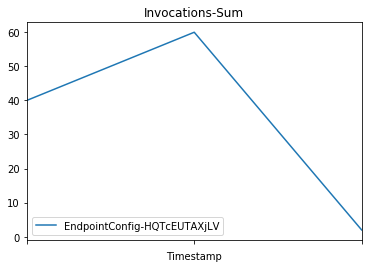

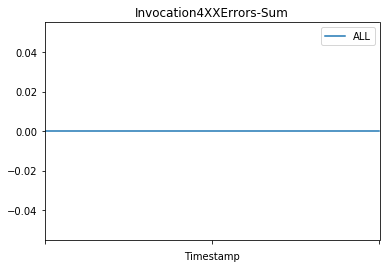

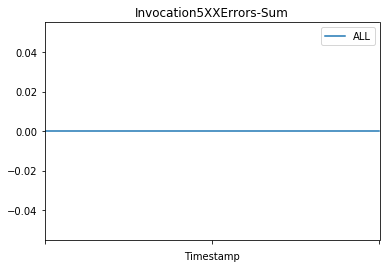

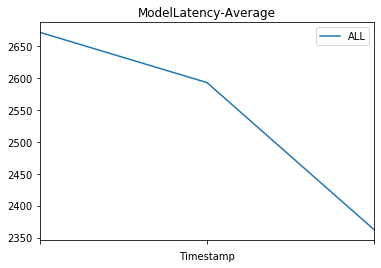

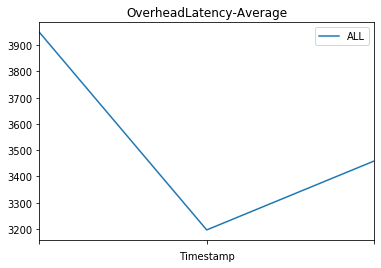

In [324]:
variant_name='AllTraffic'
ep_config_name = 'EndpointConfig-HQTcEUTAXjLV'
end_point="arn:aws:sagemaker:us-east-1:034150676293:endpoint/smgithub2-staging"
endpoint_name = "smgithub2-staging"
ep_config_2nd_name = "EndpointConfig-smgithub2-staging-CUSTOM"

invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)


### Now is the Cloud watch Alarm --

In [325]:
cw = boto3.Session().client("cloudwatch", region_name=region)
variant_name='AllTraffic'
ep_config_name = 'EndpointConfig-HQTcEUTAXjLV'
end_point="arn:aws:sagemaker:us-east-1:034150676293:endpoint/smgithub2-staging"
endpoint_name = "smgithub2-staging"
endpoint_2nd_name = "smgithub2-staging-CUSTOM"

def create_auto_rollback_alarm(
    alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold
):
    cw.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription="Test SageMaker endpoint deployment auto-rollback alarm",
        ActionsEnabled=False,
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="notBreaching",
    )

In [326]:
### NOW Create the ALARMs
error_alarm = f"TestSMGitHub2Alarm-5XXErrors-{endpoint_name}"
latency_alarm = f"TestSMGitHub2Alarm-ModelLatency-{endpoint_name}"

# alarm on 1% 5xx error rate for 1 minute
create_auto_rollback_alarm(
    error_alarm, endpoint_name, "AllTraffic", "Invocation5XXErrors", "Average", 1
)
# alarm on model latency >= 10 ms for 1 minute
create_auto_rollback_alarm(
    latency_alarm, endpoint_name, "AllTraffic", "ModelLatency", "Average", 10000
)
cw.describe_alarms(AlarmNames=[error_alarm, latency_alarm])

{'CompositeAlarms': [],
 'MetricAlarms': [{'AlarmName': 'TestSMGitHub2Alarm-5XXErrors-smgithub2-staging',
   'AlarmArn': 'arn:aws:cloudwatch:us-east-1:034150676293:alarm:TestSMGitHub2Alarm-5XXErrors-smgithub2-staging',
   'AlarmDescription': 'Test SageMaker endpoint deployment auto-rollback alarm',
   'AlarmConfigurationUpdatedTimestamp': datetime.datetime(2022, 4, 14, 15, 4, 5, 963000, tzinfo=tzlocal()),
   'ActionsEnabled': False,
   'OKActions': [],
   'AlarmActions': [],
   'InsufficientDataActions': [],
   'StateValue': 'OK',
   'StateReason': 'Threshold Crossed: no datapoints were received for 1 period and 1 missing datapoint was treated as [NonBreaching].',
   'StateReasonData': '{"version":"1.0","queryDate":"2022-04-14T15:04:27.064+0000","statistic":"Average","period":60,"recentDatapoints":[],"threshold":1.0,"evaluatedDatapoints":[{"timestamp":"2022-04-14T15:04:00.000+0000"}]}',
   'StateUpdatedTimestamp': datetime.datetime(2022, 4, 14, 15, 4, 27, 168000, tzinfo=tzlocal()),
   

### Create the BLUE Green deployment -- LINEAR --

In [327]:
linear_deployment_config = {
    "BlueGreenUpdatePolicy": {
        "TrafficRoutingConfiguration": {
            "Type": "LINEAR",
            "LinearStepSize": {
                "Type": "CAPACITY_PERCENT",
                "Value": 20,  # 33% of whole fleet capacity (33% * 3 = 1 instance)
            },
            "WaitIntervalInSeconds": 300,  # wait for 3 minutes before enabling traffic on the rest of fleet
        },
        "TerminationWaitInSeconds": 300,  # wait for 2 minutes before terminating the old stack
        "MaximumExecutionTimeoutInSeconds": 3600,  # maximum timeout for deployment
    },
    "AutoRollbackConfiguration": {
        "Alarms": [{"AlarmName": error_alarm}, {"AlarmName": latency_alarm}],
    },
}

variant_name='AllTraffic'
ep_config_name = 'EndpointConfig-HQTcEUTAXjLV'
end_point="arn:aws:sagemaker:us-east-1:034150676293:endpoint/smgithub2-staging"
endpoint_name = "smgithub2-staging"
ep_config_2nd_name = "EndpointConfig-smgithub2-staging-CUSTOM"

# update endpoint request with new DeploymentConfig parameter
sm_client.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_2nd_name,
    DeploymentConfig=linear_deployment_config,
)



ClientError: An error occurred (ValidationException) when calling the UpdateEndpoint operation: Cannot update existing endpoint using DeploymentConfig due to unsupported features. Please create new endpoint with DeploymentConfig and retry the update request, and refer documentation for a list of exclusions.

In [ ]:
print(sm_client.describe_endpoint(EndpointName=endpoint_name))
#invoke_smgithub_staging_endpoint(600, 1, False,100) # -- log every 100 steps with total of 600 invokation


In [ ]:
print(f"WAITING::Endpoint:name={endpoint_name}:: TO BE IN SERVICE")
waiter = sm_client.get_waiter('endpoint_in_service') # -- SMXGBoostCustomTweet-modelregistry-endpoint-2022-03-16-16-16-33
waiter.wait(EndpointName=endpoint_name)
print(f"Endpoint:name={endpoint_name}:: is in service")

sm_client.describe_endpoint(EndpointName=endpoint_name)

In [103]:
prediction

b'0.00022043351782485843'

In [ ]:
#sm_client = sagemaker_session.boto_session.client("sagemaker")
#sm_client.delete_endpoint(EndpointName=endpoint_name)

In [39]:
model_package_group_name

'TweetsModelPackageGroup-Example1'

### Now we query the Model Package Group and Model Package

In [75]:
sm_client = sm_session.boto_session.client("sagemaker") #boto3.Session().client('sagemaker')
# -- NOW list the model versions in the group ---
sm_client.list_model_packages(ModelPackageGroupName=model_package_group_name)

# -- find the latest MODEL Package ARN
model_of_interest_arn = ""
for models_reg in sm_client.list_model_packages(
    ModelPackageGroupName=model_package_group_name, ModelApprovalStatus="Approved")['ModelPackageSummaryList']:
    if models_reg['ModelPackageVersion'] == 9: # -- or sinmply get the latest [0] was 3 earlier 
        model_of_interest_arn= models_reg['ModelPackageArn']
        model_name_of_interest = models_reg['ModelPackageArn']
        
print(f"Version of interest model={model_of_interest_arn}::")

sm_client.list_model_packages(ModelPackageGroupName=model_package_group_name, ModelApprovalStatus="Approved")

Version of interest model=::


{'ModelPackageSummaryList': [{'ModelPackageGroupName': 'TweetsModelPackageGroup-Example1',
   'ModelPackageVersion': 7,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:034150676293:model-package/tweetsmodelpackagegroup-example1/7',
   'ModelPackageDescription': 'Test-Description',
   'CreationTime': datetime.datetime(2022, 4, 12, 21, 52, 35, 170000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'Approved'},
  {'ModelPackageGroupName': 'TweetsModelPackageGroup-Example1',
   'ModelPackageVersion': 6,
   'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:034150676293:model-package/tweetsmodelpackagegroup-example1/6',
   'ModelPackageDescription': 'Test-Description',
   'CreationTime': datetime.datetime(2022, 4, 12, 21, 33, 27, 984000, tzinfo=tzlocal()),
   'ModelPackageStatus': 'Completed',
   'ModelApprovalStatus': 'Approved'}],
 'ResponseMetadata': {'RequestId': '7723fda4-d66c-4013-be90-0ddd1cee85ad',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz

In [78]:
sm_client.describe_model_package(ModelPackageName='arn:aws:sagemaker:us-east-1:034150676293:model-package/tweetsmodelpackagegroup-example1/6')  


{'ModelPackageGroupName': 'TweetsModelPackageGroup-Example1',
 'ModelPackageVersion': 6,
 'ModelPackageArn': 'arn:aws:sagemaker:us-east-1:034150676293:model-package/tweetsmodelpackagegroup-example1/6',
 'ModelPackageDescription': 'Test-Description',
 'CreationTime': datetime.datetime(2022, 4, 12, 21, 33, 27, 984000, tzinfo=tzlocal()),
 'InferenceSpecification': {'Containers': [{'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1',
    'ImageDigest': 'sha256:3a8057603ec63256677e45e545f17986102d8d4ea8516b278343d7bd72c08257',
    'ModelDataUrl': 's3://sagemaker-grewaltempl/pipeline/model/xgbtrain/modeltweet/pipelines-whvwleu714j3-TrainTweetsStep-THACBHaQVT/output/model.tar.gz'}],
  'SupportedTransformInstanceTypes': ['ml.m5.large'],
  'SupportedRealtimeInferenceInstanceTypes': ['ml.t2.medium', 'ml.m5.large'],
  'SupportedContentTypes': ['text/csv'],
  'SupportedResponseMIMETypes': ['text/csv']},
 'ModelPackageStatus': 'Completed',
 'ModelPackageStatusDetails': {